<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Machine Vision Learning
</font>
<hr/>
<font color="#800080" size=5>
LAB 2 : LDA FIsher
<br>
</font>
<font size=5>
Instructor: Dr. H. Mohammad Zadeh
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
</font>

</div></font>

In [1]:
Name = "Ali Sadeghian"
SN = "400101464"

## Introduction

This notebook covers an implementation of **Principal Component Analysis (PCA)** for dimensionality reduction, followed by **Linear Discriminant Analysis (LDA)** for classification. The main tasks include:

1. **PCA for Feature Reduction**: Reducing the dimensionality of the data to remove noise and irrelevant features, helping improve computational efficiency.
2. **Fisher LDA for Class Separation**: Projecting data onto a new space to maximize the separation between two classes, here used to classify facial expressions.
3. **K-Nearest Neighbors (KNN) for Classification**: Classifying the data in the reduced space using KNN and analyzing accuracy with different numbers of PCA components.

## Libraries

In [2]:
import zipfile
from io import BytesIO
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import cv2
import zipfile
from PIL import Image, ImageDraw
from sklearn.linear_model import LinearRegression
import random
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier


## Principal Component Analysis (PCA)

PCA is used to reduce the dimensionality of the dataset by projecting it onto a smaller number of components. This helps in:

- Reducing computational load.
- Minimizing noise by discarding less important components.
- Preparing the data for LDA by removing unnecessary dimensions.

Below, we initialize PCA, fit it to the training data, and transform the data to the desired number of principal components.


## Linear Discriminant Analysis (LDA)

LDA is a supervised learning method that finds the linear combination of features that best separate two or more classes. Here, we use Fisher's LDA to find a line that maximizes the between-class scatter and minimizes the within-class scatter.

This will help distinguish between the two facial expressions (`happy` and `surprised`) by projecting the data onto an axis that emphasizes class separability.



## Classification with K-Nearest Neighbors (KNN)

After transforming the data using PCA and LDA, we apply KNN classification. The accuracy of KNN will be measured for different numbers of neighbors (`k`) and different values of PCA components. This analysis helps understand the influence of dimensionality reduction on classification performance.


### Loading data and Visualizing data

In this section, we load the image data, convert it to grayscale, and display samples from each category for visual inspection. This process involves several steps:

### 1. Reading and Converting Images
We use a custom function to load images directly from a zip file. The function:
- Opens the zip file and filters out PNG files from the specified folder.
- Reads each image, converts it to grayscale to simplify data processing, and stores it in a list.

Grayscale images are less complex than color images, making them easier to work with for tasks like PCA, where we aim to reduce data dimensions.

### 2. Displaying the Images
To confirm that our data is loaded correctly, we display a few images from each category. The display function:
- Creates a grid layout to show multiple images side by side.
- Optionally adds a title to indicate the category, like "Happy" or "Surprise".

This visualization helps ensure that each class’s images are loaded as expected before we move on to feature extraction.

In [3]:
# Function to read images from a zip file and convert them to grayscale
def read_images_from_zip(zip_file_path, folder_in_zip):
    gray_images = []

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as archive:
        # Filter PNG files within the specified folder
        file_list = [f for f in archive.namelist() if f.startswith(folder_in_zip) and f.endswith(".png")]

        # Read each image and convert to grayscale
        for file in file_list:
            with archive.open(file) as img_file:
                file_bytes = np.frombuffer(img_file.read(), np.uint8)
                img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray_images.append(gray_img)

    return gray_images

# Function to display a set of images
def plot_images(images, n, title=None):
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)  # Use suptitle for centered title
    plt.tight_layout()
    plt.show()

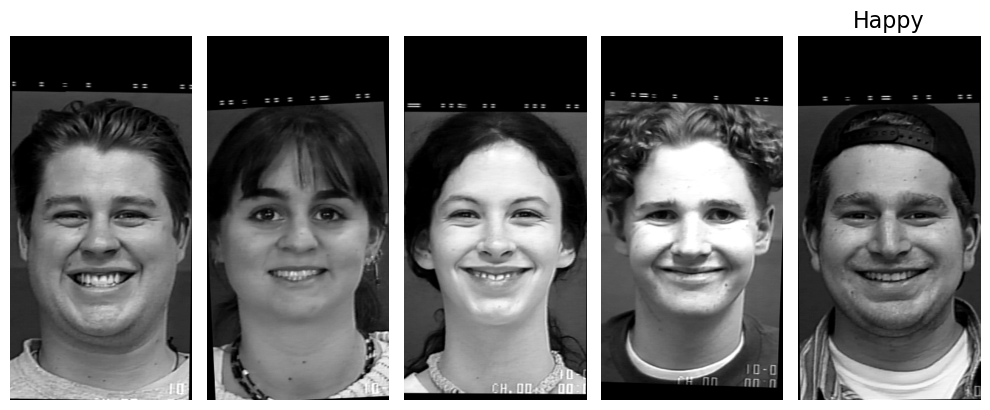

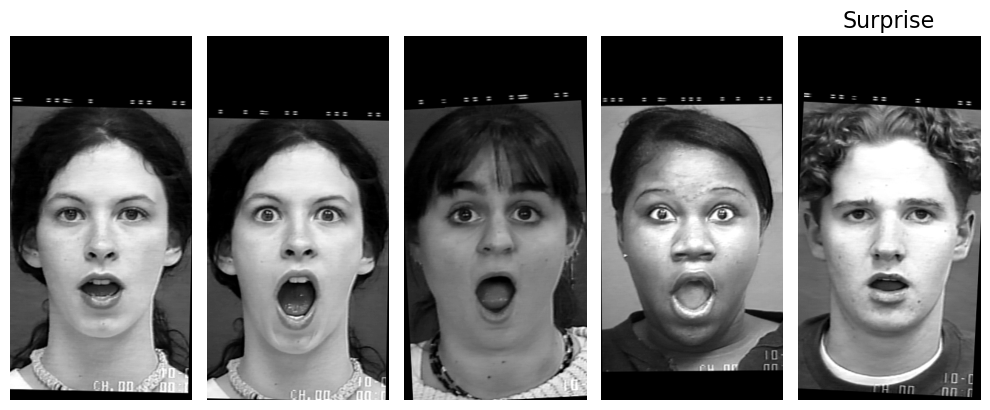

In [4]:
# Main part of the code
zip_file_path = 'data_set_image.zip'
happy_path = 'happy/'
surprise_path = 'surprise'
n_images_to_plot = 5

# Read and display grayscale images
happy_img = read_images_from_zip(zip_file_path, happy_path)
Height_h, Width_h = happy_img[0].shape

surprise_img = read_images_from_zip(zip_file_path, surprise_path)
Height_s, Width_s = happy_img[0].shape


if len(happy_img) == 0:
    print("No images found in the specified folder.")
plot_images(happy_img, n_images_to_plot,"Happy")

if len(surprise_img) == 0:
    print("No images found in the specified folder.")
plot_images(surprise_img, n_images_to_plot,"Surprise")

### Preprocessing data

In this section, we prepare our image data by creating masks to focus on facial features and by flattening the images for further analysis. This preprocessing helps to highlight relevant areas, which can improve the results of our dimensionality reduction and classification tasks.

#### 1. Creating an Elliptical Mask for Face Detection
The function `mask_face_ellipse` creates an elliptical mask centered on the face area of each image. The mask:
- Calculates the center of the image and uses it as the ellipse’s center.
- Defines the width and height of the ellipse using adjustable factors to ensure it covers the primary facial area.
- Applies the elliptical mask to the image, setting non-elliptical areas to black, which helps focus on the face and remove background noise.

#### 2. Applying the Elliptical Mask to a Dataset
The function `mask_dataset_ellipse` takes a dataset of images and applies the elliptical mask to each image. This process creates a new dataset where only the essential facial regions are visible. Masking the dataset can reduce unnecessary details, focusing on consistent features across images.

#### 3. Flattening Images for PCA
Each masked image, initially a 2D array, is then flattened to a 1D array to make it compatible with PCA. Flattening is essential for feature extraction, as PCA requires input in a 1D format for each image.

In [5]:
# Function to create an elliptical mask for face detection
def mask_face_ellipse(image, width_factor=0.8, height_factor=0.6):
    height, width = image.shape
    center_x, center_y = width // 2, height // 2
    axis_x = int(width // 2 * width_factor)
    axis_y = int(height // 2 * height_factor)

    # Create a mask using an ellipse
    mask = np.zeros_like(image, dtype=np.uint8)
    cv2.ellipse(mask, (center_x, center_y), (axis_x, axis_y), 0, 0, 360, 255, thickness=-1)

    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    return masked_image

# Function to mask a dataset of images using an elliptical mask
def mask_dataset_ellipse(dataset, width_factor=0.8, height_factor=0.6):
    masked_dataset = []
    for image in dataset:
        masked_image = mask_face_ellipse(image, width_factor, height_factor)
        masked_dataset.append(masked_image)
    return masked_dataset

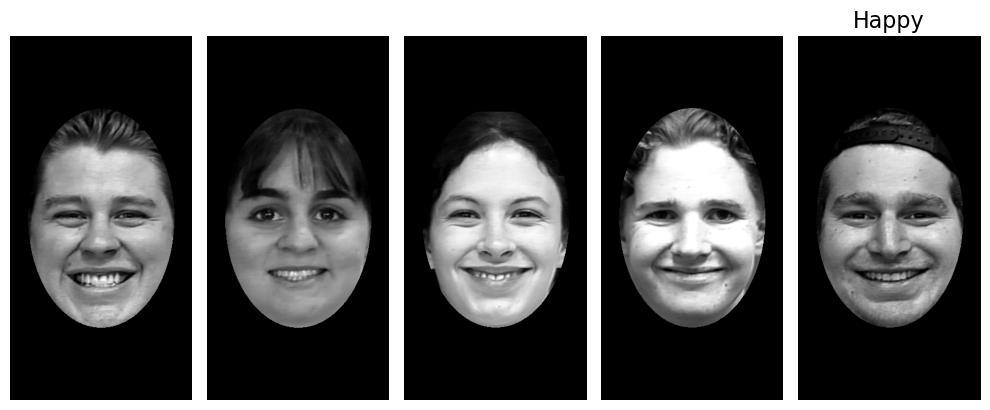

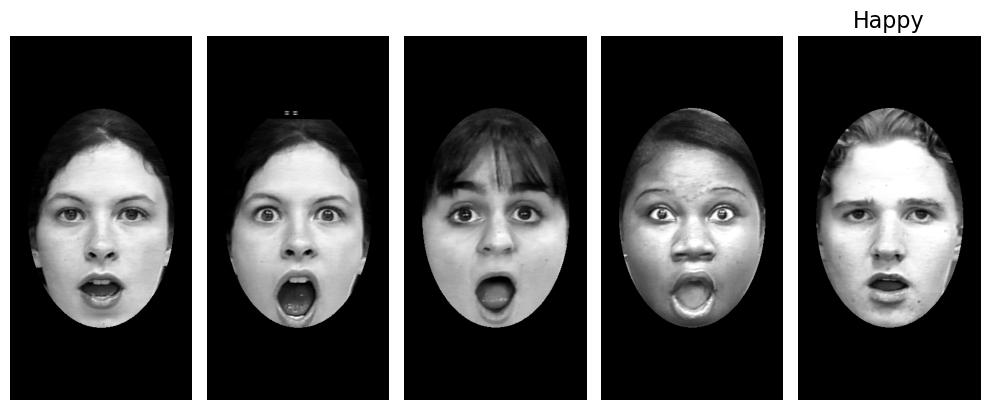

In [6]:
mask_happy_img = mask_dataset_ellipse(happy_img)
mask_surprise_img = mask_dataset_ellipse(surprise_img)

plot_images(mask_happy_img, n_images_to_plot,"Happy")
plot_images(mask_surprise_img, n_images_to_plot,"Happy")

In [7]:
# Flatten the images to prepare them for PCA
def flatten_images(images):
    return np.array([img.flatten() for img in images])

In [8]:
flattened_mask_happy_img = flatten_images(mask_happy_img)
flattened_mask_surprise_img = flatten_images(mask_surprise_img)

print(f"Flattened Happy Images Shape: {flattened_mask_happy_img.shape}")
print(f"Flattened Surprise Images Shape: {flattened_mask_surprise_img.shape}")

Flattened Happy Images Shape: (85, 180000)
Flattened Surprise Images Shape: (88, 180000)


### Creating dataset for training and testing

In this section, we prepare our data for training and testing by organizing it into classes, labeling, shuffling, and splitting it into distinct sets for training and evaluation.

#### 1. Combining and Labeling Data
First, we create a dataset by:
- **Concatenating**: We combine the "happy" and "surprise" images into a single dataset.
- **Labeling**: Each image in the "happy" class is labeled with `1`, and each "surprise" image is labeled with `0`.
  
This labeling makes it easier to distinguish between classes during training and evaluation.

#### 2. Shuffling the Data
To ensure the data order does not affect training, we shuffle the dataset and labels together. This randomization is crucial for improving the generalizability of the model.

#### 3. Splitting the Dataset into Training and Testing Sets
The function `split_train_test` divides the data and labels into training and test sets:
- For each class, it randomly selects a specified number of images (`number_of_img_per_class`) for training.
- The remaining images in each class are allocated to the test set, ensuring both sets contain a representative sample from each class.

After shuffling, splitting provides a balanced distribution across training and testing, helping the model learn the patterns in each class without overfitting.

In [9]:
number_of_img_per_class_for_train =50

# Concatenate happy and surprise images to create the dataset
data = np.concatenate((flattened_mask_happy_img, flattened_mask_surprise_img), axis=0)

# Create labels: 1 for happy, 0 for surprise
labels = np.concatenate((np.ones((len(flattened_mask_happy_img), 1)), np.zeros((len(flattened_mask_surprise_img), 1))), axis=0)

# Shuffle data and labels together
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

print(f"Data Shape: {data.shape}")    
print(f"Labels Shape: {labels.shape}") 

Data Shape: (173, 180000)
Labels Shape: (173, 1)


In [10]:
# Split the dataset and labels into training and test sets
def split_train_test(data, labels, number_of_img_per_class):
    # Identify unique classes and their indices
    classes = np.unique(labels)
    train_data_list = []
    train_labels_list = []
    test_data_list = []
    test_labels_list = []
    
    for cls in classes:
        # Get indices of the current class
        class_indices = np.where(labels.ravel() == cls)[0]
        
        # Shuffle indices for the current class
        np.random.shuffle(class_indices)
        
        # Select number_of_img_per_class for training
        train_indices = class_indices[:number_of_img_per_class]
        # Use the remaining samples for testing
        test_indices = class_indices[number_of_img_per_class:]
        
        # Append training data and labels
        train_data_list.append(data[train_indices])
        train_labels_list.append(labels[train_indices])
        
        # Append testing data and labels
        test_data_list.append(data[test_indices])
        test_labels_list.append(labels[test_indices])
    
    # Concatenate all the lists into final train and test datasets
    train_data = np.concatenate(train_data_list, axis=0)
    train_labels = np.concatenate(train_labels_list, axis=0)
    test_data = np.concatenate(test_data_list, axis=0)
    test_labels = np.concatenate(test_labels_list, axis=0)
    
    return train_data, train_labels, test_data, test_labels

# Splitting the data
train_data, train_labels, test_data, test_labels = split_train_test(data, labels,number_of_img_per_class_for_train)

print(f"Train Data Shape: {train_data.shape}, Train Labels Shape: {train_labels.shape}")
print(f"Test Data Shape: {test_data.shape}, Test Labels Shape: {test_labels.shape}")

Train Data Shape: (100, 180000), Train Labels Shape: (100, 1)
Test Data Shape: (73, 180000), Test Labels Shape: (73, 1)


### Using PCA for reducing data dimensions 

In this section, we apply **Principal Component Analysis (PCA)** to reduce the dimensionality of our dataset. Reducing dimensions helps to eliminate noise and redundant information, making the dataset more manageable for classification while retaining the most important features.

#### 1. Setting the Range for PCA Components
We define a range of component counts (`n_components_range`) to test different levels of dimensionality reduction. This range spans 20 values, from 1 to 50 components. Testing a range allows us to find the optimal number of components for balancing data reduction with model accuracy.

#### 2. Initializing PCA with Maximum Components
We set up PCA with the maximum number of components (`max_components`) defined in our range. Using the maximum ensures we retain the ability to test all specified component levels within the range.

#### 3. Fitting PCA and Transforming the Data
After initializing PCA, we:
- **Fit** PCA to the training data, which computes the principal components based on variance.
- **Transform** both training and test sets based on these computed components, effectively reducing the dimensionality for both.

The transformed datasets (`train_pca` and `test_pca`) now contain fewer features, making them ready for classification. We print the shapes of the transformed datasets to confirm the dimensionality reduction. With PCA applied, we can proceed to analyze the effect of different component counts on classification performance.

In [11]:
# Define the number of components to test
n_components_range = np.linspace(0, 50, 20, dtype=int)  # 20 values from 5 to 100
n_components_range[0] = 1

mrss_values = []  # Store MRSS values for each component count
predictions = {}  # Store predictions for plotting

# Perform PCA using SVD for the maximum number of components
max_components = n_components_range[-1]  # Maximum number of components
pca = PCA(n_components=max_components)
pca.fit(train_data)


PCA(n_components=50)

In [12]:
train_pca = pca.transform(train_data)   
test_pca = pca.transform(test_data)     

print(train_pca.shape)
print(test_pca.shape)

(100, 50)
(73, 50)


### Fisher Linear Discriminant Analysis (LDA)

In this section, we implement **Fisher's Linear Discriminant Analysis (LDA)** to find a linear combination of features that maximizes the separation between two classes. This technique is used to project our PCA-reduced data onto a new subspace that emphasizes the differences between classes.

#### 1. Calculating Scatter Matrices
To optimize class separation, we compute two scatter matrices:
- **Within-class scatter matrix** (`S_W`): Captures the spread of data within each class. Minimizing this matrix helps to cluster each class tightly.
- **Between-class scatter matrix** (`S_B`): Measures the distance between class means. Maximizing this matrix helps to spread the classes apart.

For each class, we:
- Compute the class mean and then use it to calculate `S_W` by measuring deviations within the class.
- Calculate `S_B` by measuring the deviation of the class mean from the overall mean, scaled by the number of samples in that class.

#### 2. Finding Eigenvalues and Eigenvectors
Using the scatter matrices, we:
- Compute the eigenvalues and eigenvectors of the matrix $ S_W^{-1} S_B $, which represent the directions that best separate the classes.
- Sort these eigenvectors by their eigenvalues in descending order to prioritize the directions with the most discriminative power.

#### 3. Visualizing Fisher Vectors
The top eigenvectors (known as Fisher vectors) are reshaped and visualized as images, allowing us to see the features that are most relevant for distinguishing between the two classes. These visualizations are helpful in understanding which facial areas are emphasized in classification.

#### 4. Projecting Data onto Fisher Vectors
After selecting the top eigenvectors (typically equal to the number of classes minus one), we project both training and test data onto these Fisher vectors, creating a lower-dimensional representation that maximizes class separability.

#### 5. Finding the Optimal Threshold
We determine the best threshold for classification by:
- Testing a range of threshold values and calculating the classification accuracy for each.
- Selecting the threshold that yields the highest accuracy on the training data.

#### 6. Classifying Test Data and Evaluating Performance
Using the optimal threshold, we classify the test data and evaluate the model:
- **Confusion Matrices**: Show the distribution of predictions vs. actual labels for both training and test sets.
- **Accuracy Scores**: Indicate the overall performance of the classifier on test data.

With Fisher LDA completed, we have projected the data onto a space that maximizes class distinction and evaluated the model’s performance. This process highlights the effectiveness of LDA in supervised dimensionality reduction and classification.

In [13]:
classes = np.unique(train_labels)
mean_total = np.mean(train_pca, axis=0)
S_W = np.zeros((train_pca.shape[1], train_pca.shape[1]))  # Within-class scatter matrix
S_B = np.zeros((train_pca.shape[1], train_pca.shape[1]))  # Between-class scatter matrix


# Calculate S_W and S_B
for cls in classes:
    class_data = train_pca[train_labels.ravel() == cls]
    class_mean = np.mean(class_data, axis=0)
    
    # Within-class scatter matrix
    S_W += np.dot((class_data - class_mean).T, (class_data - class_mean))
    
    # Between-class scatter matrix
    n_cls = class_data.shape[0]
    mean_diff = (class_mean - mean_total).reshape(-1, 1)
    S_B += n_cls * (mean_diff).dot(mean_diff.T)

eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# Sort eigenvectors by eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvectors = eigenvectors[:, sorted_indices]

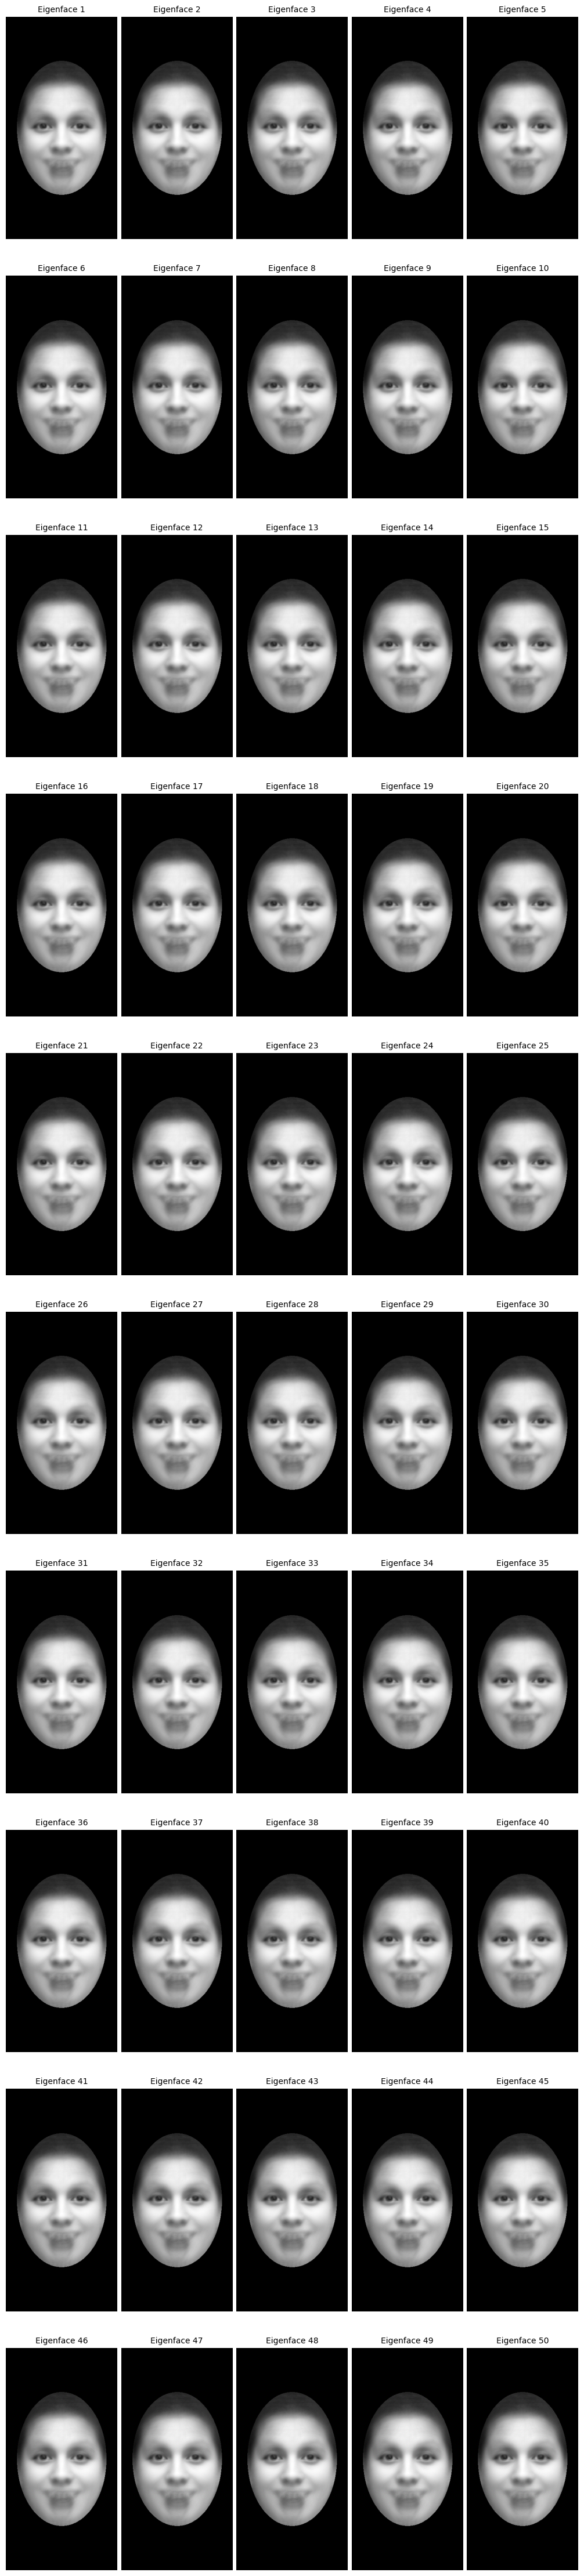

In [25]:
fisher_vectors_data_size = np.real(pca.inverse_transform(eigenvectors.T))
fisher_vectors_data_size = fisher_vectors_data_size.reshape(len(fisher_vectors_data_size),Height_h, Width_h)

# Function to display a set of images
def plot_images(eigenfaces, num_eigenfaces=10, eigenfaces_per_row=5,title =None):
    plt.figure(figsize=(eigenfaces_per_row*2,num_eigenfaces*0.9))  # Adjusted figure size for better control
    rows = (num_eigenfaces + eigenfaces_per_row - 1) // eigenfaces_per_row  # n eigenfaces per row

    for i in range(num_eigenfaces):
        plt.subplot(rows, eigenfaces_per_row, i + 1)
        plt.imshow(eigenfaces[i], cmap='gray')
        plt.title(f'Eigenface {i + 1}', fontsize=10)
        plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)  # Use suptitle for centered title
    plt.subplots_adjust(wspace=0.05, hspace=0)  # Reduce spacing between plots
    plt.tight_layout(pad=0.5)  # Minimize padding
    plt.show()

plot_images(fisher_vectors_data_size,len(fisher_vectors_data_size))

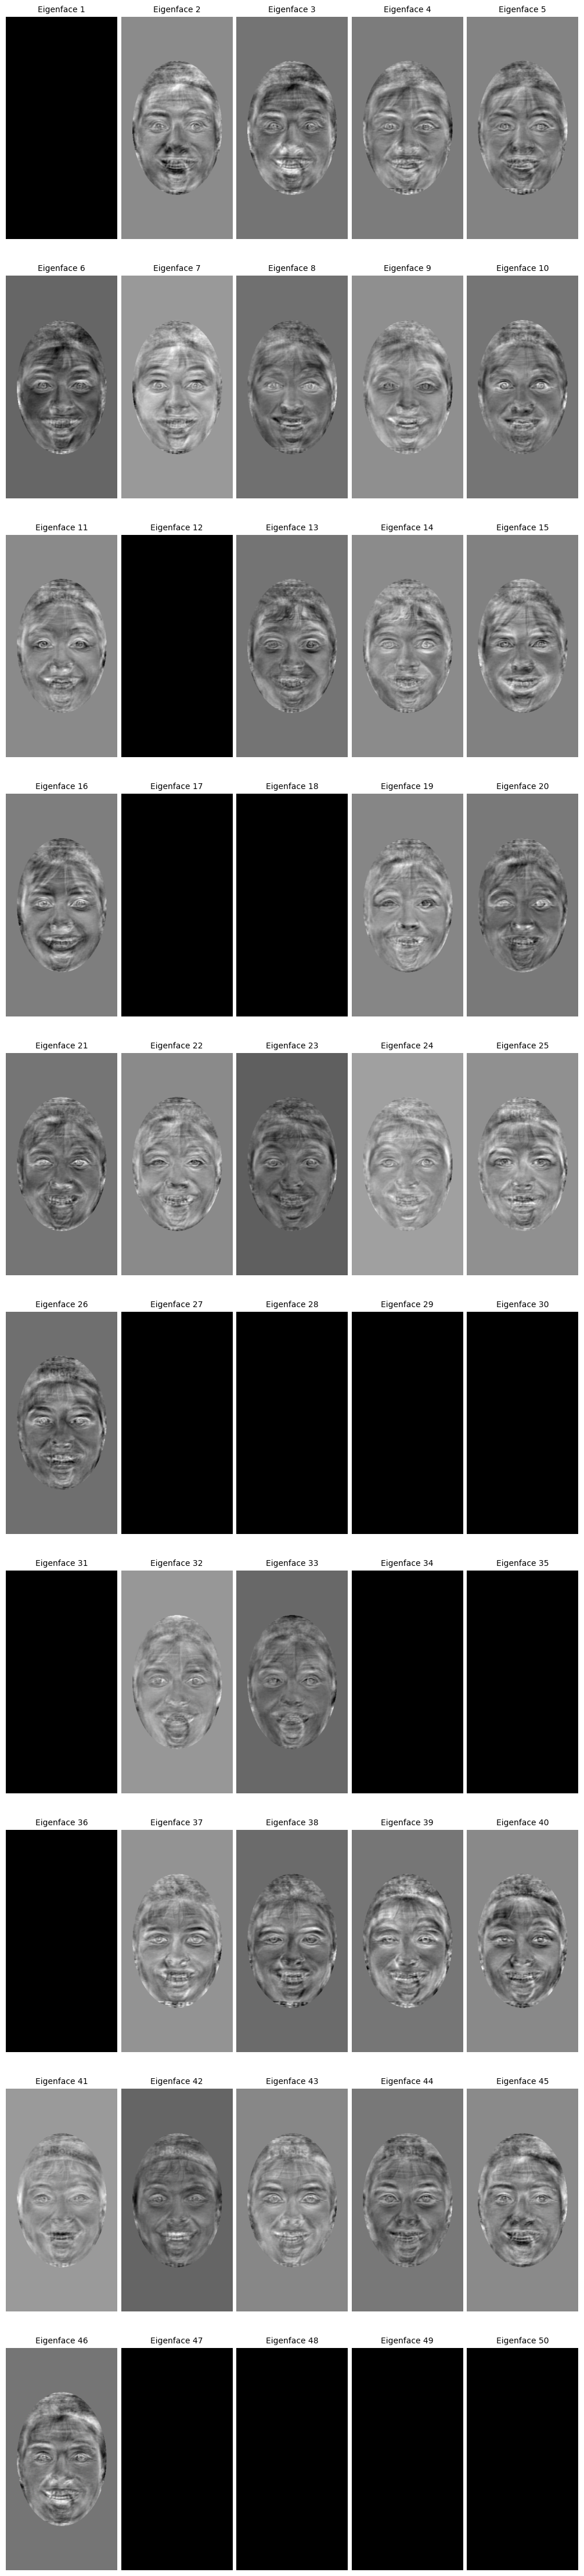

In [24]:
fisher_vectors_data_size = np.imag(pca.inverse_transform(eigenvectors.T))
fisher_vectors_data_size = fisher_vectors_data_size.reshape(len(fisher_vectors_data_size),Height_h, Width_h)

# Function to display a set of images
def plot_images(eigenfaces, num_eigenfaces=10, eigenfaces_per_row=5,title =None):
    plt.figure(figsize=(eigenfaces_per_row*2,num_eigenfaces*0.9))  # Adjusted figure size for better control
    rows = (num_eigenfaces + eigenfaces_per_row - 1) // eigenfaces_per_row  # n eigenfaces per row

    for i in range(num_eigenfaces):
        plt.subplot(rows, eigenfaces_per_row, i + 1)
        plt.imshow(eigenfaces[i], cmap='gray')
        plt.title(f'Eigenface {i + 1}', fontsize=10)
        plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)  # Use suptitle for centered title
    plt.subplots_adjust(wspace=0.05, hspace=0)  # Reduce spacing between plots
    plt.tight_layout(pad=0.5)  # Minimize padding
    plt.show()

plot_images(fisher_vectors_data_size,len(fisher_vectors_data_size))

### Analysis of Fisher Vectors (Fisherfaces) and Their Reconstructed Images in Pixel Space

#### 1. Number of Fisher Vectors Obtained
In this analysis, the Linear Discriminant Analysis (LDA) was applied to two classes: "happy" and "surprise." Since LDA produces $C - 1$ Fisher vectors for $C$ classes ($ S_W^{-1} S_B $ is $50 \times 50$ matrix so it has $50$ eigen vectors ), we obtained one Fisher vector as a result of the process. This vector captures the primary features that differentiate between the "happy" and "surprise" expressions in the dataset.

#### 2. Reconstruction of Fisher Vector in Pixel Space
To visualize the Fisher vector in pixel space, the vector was transformed back using the inverse of the dimensionality reduction technique (in this case, PCA) that was applied prior to LDA. This reconstruction allows the Fisher vector, which exists in a lower-dimensional space, to be interpreted in terms of the original pixel layout, producing an image that resembles a face, similar to eigenfaces.

#### 3. Interpretation of the Reconstructed Image
The reconstructed image derived from the Fisher vector was analyzed to understand the regions it highlights, which correspond to areas of significant class-distinguishing features. The analysis of bright and dark areas in this image is as follows:

- **Bright Areas**: These regions indicate significant variance between the two expressions. Since the Fisher vector was trained to differentiate between "happy" and "surprise," the bright areas likely correspond to facial features that vary most between these expressions. For example, these might include:
  - The mouth region, where a smile or open mouth is associated with a "happy" or "surprise" expression.
  - The eyes and eyebrows, which often exhibit noticeable changes in shape and positioning between different emotional expressions.

- **Dark Areas**: These regions correspond to areas with less variance, suggesting they play a less significant role in distinguishing between the two expressions. Dark areas likely represent more static facial regions, such as the sides of the face or parts of the forehead, where features remain relatively constant across expressions.


Optimal Threshold: (-620.4111594388614+0j)
Training Accuracy at Optimal Threshold: 100.00%
Test Accuracy: 94.52%


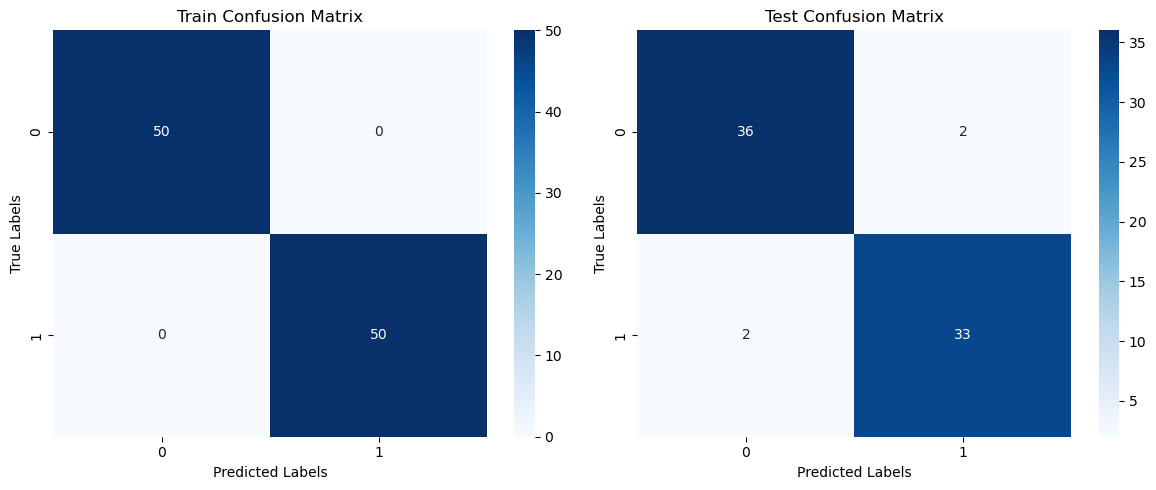

In [15]:
# Project PCA-transformed data onto Fisher vectors
# Select top k eigenvectors (k is typically the number of classes - 1)
k = len(classes) - 1
fisher_vectors = eigenvectors[:, :k]

train_lda = train_pca.dot(fisher_vectors)
test_lda = test_pca.dot(fisher_vectors)

# Find the optimal threshold on training data
# Define range for threshold search based on min and max values in the projected train data
thresholds = np.linspace(train_lda.min(), train_lda.max(), 100)
best_accuracy = 0
best_threshold = None

for threshold in thresholds:
    # Predict labels for training data based on current threshold
    train_predictions = (train_lda >= threshold).astype(int).ravel()
    
    # Calculate accuracy
    accuracy = accuracy_score(train_labels, train_predictions)
    
    # Update the best threshold if current accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Optimal Threshold: {best_threshold}")
print(f"Training Accuracy at Optimal Threshold: {best_accuracy * 100:.2f}%")

# Classify test data using the optimal threshold
test_predictions = (test_lda >= best_threshold).astype(int).ravel()

# Calculate confusion matrices and accuracy
train_confusion = confusion_matrix(train_labels, (train_lda >= best_threshold).astype(int).ravel())
test_confusion = confusion_matrix(test_labels, test_predictions)

test_accuracy = accuracy_score(test_labels, test_predictions)

# Print accuracies
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot train confusion matrix
sns.heatmap(train_confusion, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Train Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Plot test confusion matrix
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Test Confusion Matrix')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

### Linear Discriminant Analysis (LDA) with Different Principal Component Counts

In this section we perform Linear Discriminant Analysis (LDA) on Principal Component Analysis (PCA)-transformed data to find the best number of components for classification. The process is carried out for a range of PCA component counts, and for each count, the LDA is trained and evaluated on both training and testing data. The misclassification rates are calculated to analyze model performance.

In [16]:
mrss_values_Train = []  # Store misclassification rate for each component count
mrss_values_Test = []
# Loop through each component count
for n_components in n_components_range:
    # Perform PCA with the current number of components
    train_pca = pca.fit_transform(train_data)[:, :n_components]   
    test_pca = pca.transform(test_data)[:, :n_components]
    
    # Fisher LDA on PCA-transformed data
    classes = np.unique(train_labels)
    mean_total = np.mean(train_pca, axis=0)
    S_W = np.zeros((train_pca.shape[1], train_pca.shape[1]))  # Within-class scatter matrix
    S_B = np.zeros((train_pca.shape[1], train_pca.shape[1]))  # Between-class scatter matrix

    # Calculate S_W and S_B
    for cls in classes:
        class_data = train_pca[train_labels.ravel() == cls]
        class_mean = np.mean(class_data, axis=0)
        
        # Within-class scatter matrix
        S_W += np.dot((class_data - class_mean).T, (class_data - class_mean))
        
        # Between-class scatter matrix
        n_cls = class_data.shape[0]
        mean_diff = (class_mean - mean_total).reshape(-1, 1)
        S_B += n_cls * (mean_diff).dot(mean_diff.T)

    # Eigen decomposition for Fisher LDA
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Use top (number of classes - 1) Fisher eigenvectors
    k = len(classes) - 1
    fisher_vectors = eigenvectors[:, :k]

    # Project PCA-transformed data onto Fisher vectors
    train_lda = train_pca.dot(fisher_vectors)
    test_lda = test_pca.dot(fisher_vectors)

    # Find optimal threshold based on accuracy for the training data
    thresholds = np.linspace(train_lda.min(), train_lda.max(), 100)
    best_accuracy = 0
    best_threshold = None
    
    for threshold in thresholds:
        # Predict labels for training data
        train_predictions = (train_lda >= threshold).astype(int).ravel()
        accuracy = accuracy_score(train_labels, train_predictions)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    # Test data predictions using the optimal threshold
    test_predictions = (test_lda >= best_threshold).astype(int).ravel()
    test_accuracy = accuracy_score(test_labels, test_predictions)

    # Calculate misclassification rate for plotting
    mrss_values_Test.append(1 - test_accuracy)
    mrss_values_Train.append(1 - best_accuracy)


### K-Nearest Neighbors (K-NN) with Principal Component Analysis (PCA)

In this part we apply the K-Nearest Neighbors (K-NN) algorithm on data transformed by Principal Component Analysis (PCA) and evaluates the performance at different PCA component counts and K values. The misclassification rates for each combination of component count and K value are calculated for both training and testing datasets.

In [30]:
k_values = [1, 3, 5]

mrss_values_Train_k = {k: [] for k in k_values}  # Store misclassification rate for each component count for train
mrss_values_Test_k = {k: [] for k in k_values}   # Store misclassification rate for each component count for test

# Loop through each component count
for n_components in n_components_range:
    # Perform PCA with the current number of components
    train_pca = pca.fit_transform(train_data)[:, :n_components]   
    test_pca = pca.transform(test_data)[:, :n_components]

    # Loop through each K value for K-NN
    for k in k_values:
        # Create and fit K-NN classifier
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train_pca, train_labels.ravel())

        # Calculate training accuracy
        train_predictions = knn.predict(train_pca)
        train_accuracy = accuracy_score(train_labels, train_predictions)
        mrss_values_Train_k[k].append(1 - train_accuracy)  # Misclassification rate for train

        # Calculate test accuracy
        test_predictions = knn.predict(test_pca)
        test_accuracy = accuracy_score(test_labels, test_predictions)
        mrss_values_Test_k[k].append(1 - test_accuracy)  # Misclassification rate for test

### Comparison between two models

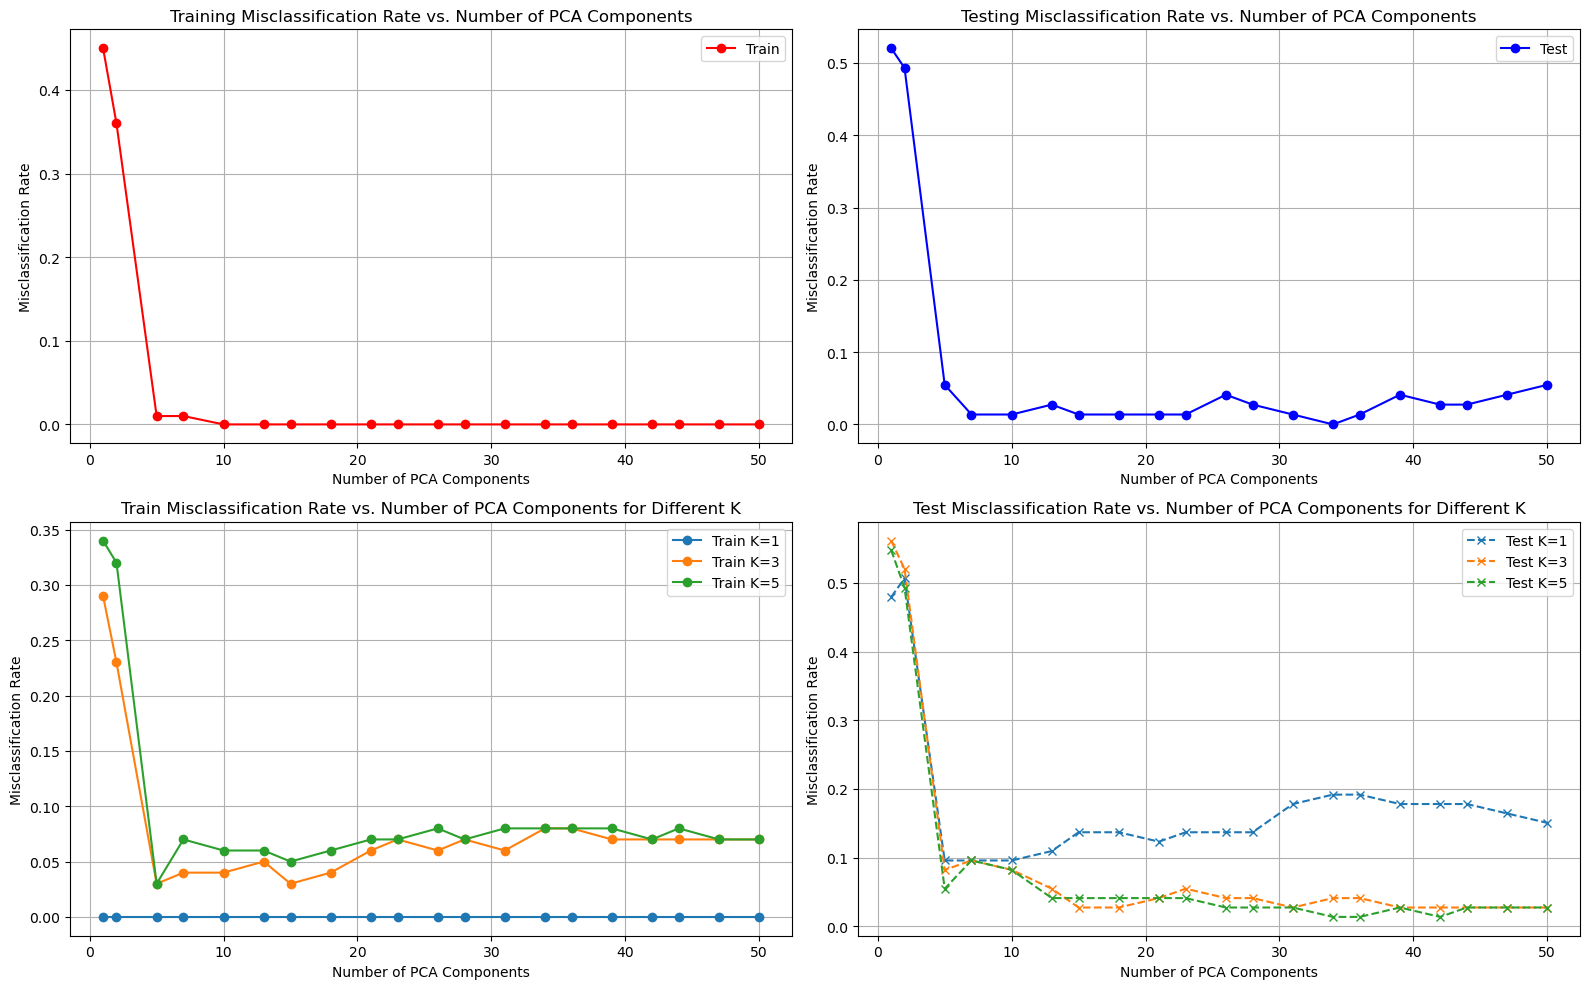

In [18]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# First subplot: Training misclassification rate
axs[0, 0].plot(n_components_range, mrss_values_Train, marker='o', linestyle='-', color='r', label="Train")
axs[0, 0].set_xlabel('Number of PCA Components')
axs[0, 0].set_ylabel('Misclassification Rate')
axs[0, 0].set_title('Training Misclassification Rate vs. Number of PCA Components')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Second subplot: Test misclassification rate
axs[0, 1].plot(n_components_range, mrss_values_Test, marker='o', linestyle='-', color='b', label="Test")
axs[0, 1].set_xlabel('Number of PCA Components')
axs[0, 1].set_ylabel('Misclassification Rate')
axs[0, 1].set_title('Testing Misclassification Rate vs. Number of PCA Components')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Third subplot: Misclassification rate for different K values in Training data
for k in k_values:
    axs[1, 0].plot(n_components_range, mrss_values_Train_k[k], marker='o', linestyle='-', label=f'Train K={k}')
axs[1, 0].set_xlabel('Number of PCA Components')
axs[1, 0].set_ylabel('Misclassification Rate')
axs[1, 0].set_title('Train Misclassification Rate vs. Number of PCA Components for Different K')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Fourth subplot: Misclassification rate for different K values in Test data
for k in k_values:
    axs[1, 1].plot(n_components_range, mrss_values_Test_k[k], marker='x', linestyle='--', label=f'Test K={k}')
axs[1, 1].set_xlabel('Number of PCA Components')
axs[1, 1].set_ylabel('Misclassification Rate')
axs[1, 1].set_title('Test Misclassification Rate vs. Number of PCA Components for Different K')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Analysis of LDA and K-NN Model Performance with PCA

The performance of Linear Discriminant Analysis (LDA) and K-Nearest Neighbors (K-NN) models with varying numbers of PCA components reveals important insights into how these models respond to dimensionality reduction.

#### LDA Model Performance
- **Training Data**: The training misclassification rate for the LDA model decreases steadily as the number of PCA components increases. After approximately 10 components, the training error reaches zero, indicating that the LDA model achieves perfect classification on the training data from this point onward.
- **Testing Data**: The test misclassification rate for LDA initially drops sharply, reaching a low value around 8 components. However, as the number of components increases further, particularly after 35 components, there is a noticeable increase in the test error. This trend suggests that while LDA benefits from dimensionality reduction, too many components may lead to overfitting, where the model's performance on unseen data declines.

#### K-NN Model Performance with Different K Values
- **Training Data (K=1)**: For K-NN with $ K=1 $, the training misclassification rate is consistently zero across all numbers of PCA components, indicating that the model perfectly classifies the training data regardless of dimensionality. This is expected for $ K=1 $ in K-NN, as the model may overfit the training data.
- **Training Data ($K=3 and K=5$)**: For $ K=3 $ and $ K=5 $, the training error starts higher but decreases from around 1 to 6 components, after which it stabilizes and shows little to no change. This stability in misclassification rates suggests that moderate values of K introduce a slight regularization effect, reducing the likelihood of overfitting compared to $ K=1 $.
- **Testing Data**: On the test data, the misclassification rates for all values of K decrease as the number of PCA components increases up to around 8 components. Beyond this point, for $ K=1 $, the test error starts to increase, indicating overfitting when too many components are used. Conversely, for $ K=3 $ and $ K=5 $, the test error continues to decrease slightly, indicating better generalization in higher-dimensional spaces.

#### Overall Comparison
In summary, LDA demonstrates superior performance with a lower number of PCA components, achieving low misclassification rates with fewer dimensions. However, as the number of components increases, LDA tends to overfit, which degrades its performance on test data. In contrast, K-NN with $ K=3 $ and $ K=5 $ performs better at higher component counts, where it maintains lower misclassification rates on test data. Among the K-NN models, $ K=3 $ and $ K=5 $ yield consistently lower test errors compared to $ K=1 $, especially at higher dimensionalities, indicating that they are more robust against overfitting in the presence of increased feature space.

This comparative analysis highlights the need to select an appropriate number of PCA components and the optimal K value based on the specific model and dataset characteristics to achieve the best balance between training accuracy and generalization on unseen data.
